# Visual Diagnosis of Text Analysis with Baleen 

This notebook has been created as part of the [Yellowbrick user study](http://www.scikit-yb.org/en/latest/evaluation.html). I hope to explore how visual methods might improve the workflow of text classification on a small to medium sized corpus. 

## Dataset 

The dataset used in this study is a sample of the [Baleen Corpus](http://baleen.districtdatalabs.com/). The Baleen corpus has been ingesting RSS feeds on the hour from a variety of topical feeds since March 2016, including news, hobbies, and political documents and currently has over 1.2M posts from 373 feeds. [Baleen](https://github.com/bbengfort/baleen) (an open source system) has a sister library called [Minke](https://github.com/bbengfort/minke) that provides multiprocessing support for dealing with Gigabytes worth of text. 

The dataset I'll use in this study is a sample of the larger data set that contains 68,052 or roughly 6% of the total corpus. For this test, I've chosen to use the preprocessed corpus, which means I won't have to do any tokenization, but can still apply normalization techniques. The corpus is described as follows:

Baleen corpus contains 68,052 files in 12 categories.
Structured as:

- 1,200,378 paragraphs (17.639 mean paragraphs per file)
- 2,058,635 sentences (1.715 mean sentences per paragraph).

Word count of 44,821,870 with a vocabulary of 303,034 (147.910 lexical diversity).

Category Counts: 

- books: 1,700 docs
- business: 9,248 docs
- cinema: 2,072 docs
- cooking: 733 docs
- data science: 692 docs
- design: 1,259 docs
- do it yourself: 2,620 docs
- gaming: 2,884 docs
- news: 33,253 docs
- politics: 3,793 docs
- sports: 4,710 docs
- tech: 5,088 docs

This is quite a lot of data, so for now we'll simply create a classifier for the "hobbies" categories: e.g. books, cinema, cooking, diy, gaming, and sports. 

Note: this data set is not currently publically available, but I am happy to provide it on request. 

In [1]:
%matplotlib inline 

In [5]:
import os 
import sys 
import nltk
import pickle

# To import yellowbrick 
sys.path.append("../..")

### Loading Data 

In order to load data, I'd typically use a `CorpusReader`. However, for the sake of simplicity, I'll load data using some simple Python generator functions. I need to create two primary methods, the first loads the documents using pickle, and the second returns the vector of targets for supervised learning. 

In [3]:
CORPUS_ROOT = os.path.join(os.getcwd(), "data") 
CATEGORIES = ["books", "cinema", "cooking", "diy", "gaming", "sports"]

def fileids(root=CORPUS_ROOT, categories=CATEGORIES): 
    """
    Fetch the paths, filtering on categories (pass None for all). 
    """
    for name in os.listdir(root):
        dpath = os.path.join(root, name)
        if not os.path.isdir(dpath):
            continue 
        
        if categories and name in categories: 
            for fname in os.listdir(dpath):
                yield os.path.join(dpath, fname)


def documents(root=CORPUS_ROOT, categories=CATEGORIES):
    """
    Load the pickled documents and yield one at a time. 
    """
    for path in fileids(root, categories):
        with open(path, 'rb') as f:
            yield pickle.load(f)


def labels(root=CORPUS_ROOT, categories=CATEGORIES):
    """
    Return a list of the labels associated with each document. 
    """            
    for path in fileids(root, categories):
        dpath = os.path.dirname(path) 
        yield dpath.split(os.path.sep)[-1]

### Feature Extraction and Normalization 

In order to conduct analyses with Scikit-Learn, I'll need some helper transformers to modify the loaded data into a form that can be used by the `sklearn.feature_extraction` text transformers. I'll be mostly using the `CountVectorizer` and `TfidfVectorizer`, so these normalizer transformers and identity functions help a lot. 

In [52]:
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 
from unicodedata import category as ucat
from nltk.corpus import stopwords as swcorpus
from sklearn.base import BaseEstimator, TransformerMixin 


def identity(args):
    """
    The identity function is used as the "tokenizer" for 
    pre-tokenized text. It just passes back it's arguments. 
    """
    return args 


def is_punctuation(token):
    """
    Returns true if all characters in the token are
    unicode punctuation (works for most punct). 
    """
    return all(
        ucat(c).startswith('P')
        for c in token 
    )


def wnpos(tag):
    """
    Returns the wn part of speech tag from the penn treebank tag. 
    """
    return {
        "N": wn.NOUN,
        "V": wn.VERB,
        "J": wn.ADJ, 
        "R": wn.ADV, 
    }.get(tag[0], wn.NOUN)


class TextNormalizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, stopwords='english', lowercase=True, lemmatize=True, depunct=True):
        self.stopwords  = frozenset(swcorpus.words(stopwords)) if stopwords else frozenset()
        self.lowercase  = lowercase 
        self.depunct    = depunct 
        self.lemmatizer = WordNetLemmatizer() if lemmatize else None 
    
    def fit(self, docs, labels=None):
        return self

    def transform(self, docs): 
        for doc in docs: 
            yield list(self.normalize(doc)) 
    
    def normalize(self, doc):
        for paragraph in doc:
            for sentence in paragraph:
                for token, tag in sentence: 
                    if token.lower() in self.stopwords:
                        continue 
                    
                    if self.depunct and is_punctuation(token):
                        continue 
                    
                    if self.lowercase:
                        token = token.lower() 
                    
                    if self.lemmatizer:
                        token = self.lemmatizer.lemmatize(token, wnpos(tag))
                    
                    yield token 

### Corpus Analysis 

At this stage, I'd like to get a feel for what was in my corpus, so that I can start thinking about how to best vectorize the text and do different types of counting. With the Yellowbrick 0.3.3 release, support has been added for two text visualizers, which I think I will test out at scale using this corpus. 

AttributeError: 'NoneType' object has no attribute 'transform'

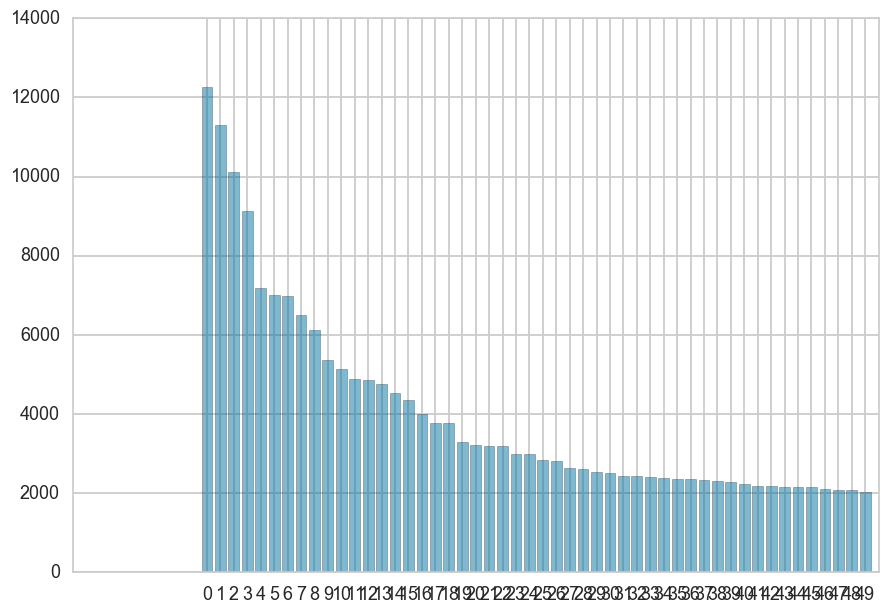

In [53]:
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import CountVectorizer 
from yellowbrick.text import FreqDistVisualizer

visualizer = Pipeline([
    ('norm', TextNormalizer()),
    ('count', CountVectorizer(tokenizer=lambda x: x, preprocessor=None, lowercase=False)),
    ('viz', FreqDistVisualizer())
])

visualizer.fit_transform(documents(), labels())
visualizer.named_steps['viz'].poof()

/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


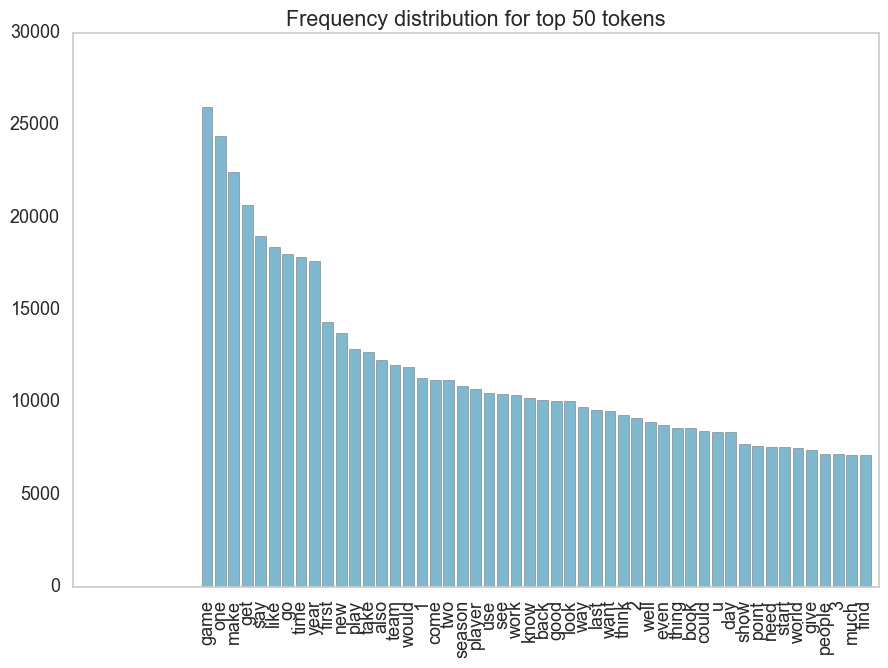

In [57]:
vect = Pipeline([
    ('norm', TextNormalizer()),
    ('count', CountVectorizer(tokenizer=lambda x: x, preprocessor=None, lowercase=False)),
])

docs = vect.fit_transform(documents(), labels())
viz = FreqDistVisualizer() 
viz.fit(docs, vect.named_steps['count'].get_feature_names())
viz.poof()